In [12]:
'''Import'''
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import time 
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

from scipy.interpolate import NearestNDInterpolator

from clmmodtools import *
import shutil

#ML
from sklearn.gaussian_process import GaussianProcessRegressor 

In [2]:
def blackbox_clm(baseflow, fmax, slopebeta, fff):
    #change parameter in netcdf file
    target_surface_file = '/glade/work/marielj/inputdata/lnd/clm2/surfdata_map/hillslope/surfdata_1x1pt_US-MBP_hist_16pfts_Irrig_CMIP6_simyr2000_HAND_3_col_hillslope_lagg_pft_soildepth.nc'
    target_param1 = 'baseflow_scalar'
    target_param2 = 'FMAX' 
    
    #change fmax
    change_surf_param(target_param2, fmax, 0, target_surface_file)
    
    os.chdir(CASE_DIR)
    
    #change baseflow_scalar
    change_nl_param(target_param1, baseflow)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h2.2015-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h2.2015-01-01-00000.nc')
    mod = dat.QRUNOFF.values.reshape(365)
    meas = np.array(stream['Flow_mms'])
    
    #Compute correlation
    r2_plot = rsquared(meas, mod)
    
    #remove data
    os.remove(CASE_NAME + '.clm2.h2.2015-01-01-00000.nc')
    
    #return average annual WTE
    return r2_plot

acquisition_function = UtilityFunction(kind = "ucb", kappa = 10e2)

In [3]:
'''Load Optimizer'''
clm_optimizer = BayesianOptimization(f = blackbox_clm, 
                                    pbounds = {'baseflow': (0,10),
                                               'fmax': (0, 1), 
                                               'slopebeta' : (-10e2, 10), 
                                               'fff' : (0.1, 5)}, 
                                    random_state = 75832, 
                                    verbose = 0
                                    )
#logger object records optimization search
load_logs(clm_optimizer, logs=["./logs/hillslope_logs_seanmods_wte.json"])

In [4]:
print("New optimizer is now aware of {} points.".format(len(clm_optimizer.space)))

New optimizer is now aware of 150 points.


Text(0, 0.5, '$R^2')

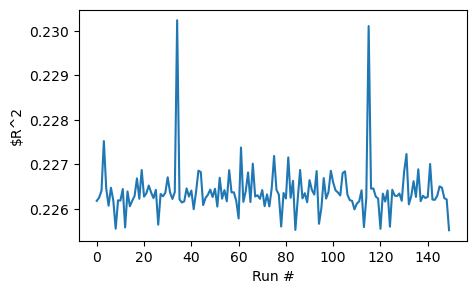

In [5]:
#R2 values - model fit
x = [res["target"] for res in clm_optimizer.res]

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
ax.plot(x)
ax.set_xlabel('Run #')
ax.set_ylabel(r'$R^2')

In [6]:
def plot_gp_2D(optimizer, aq, it, param1, param2, param1_min, param1_max, param2_min, param2_max):
    #Setup 
    #Breakdown Data
    max_ = optimizer.max
    res = optimizer.res[:it]
    x_ = np.array([r["params"][param1] for r in res])
    y_ = np.array([r["params"][param2] for r in res])
    z_ = np.array([r["target"] for r in res])

    #Model Results
    ser = pd.Series(z_, index=[y_, x_])
    Z = ser.unstack().fillna(np.nan)

    #Range space
    l1 = len(Z.columns) 
    l2 = len(Z.index)
    x1 = np.linspace(param1_min, param1_max, l1).reshape(-1, 1)
    x2 = np.linspace(param2_min, param2_max, l2).reshape(-1, 1)
    xmesh, ymesh = np.meshgrid(x1, x2)
    xy = np.array(list(zip(xmesh.reshape(l1*l2, 1), ymesh.reshape(l1*l2, 1)))).reshape(l1*l2,2)
    
    #Plot
    fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6,6))

    #Axis 1: Function Estimate
    interp = NearestNDInterpolator(list(zip(x_, y_)), z_)
    mesh1 = axs.pcolormesh(Z.columns, Z.index, interp(xy).reshape(l2, l1), cmap=plt.cm.coolwarm)
    #mesh1 = axs.imshow(interpgrid, cmap=plt.cm.coolwarm, aspect = 'auto')
    axs.scatter(x_, y_, c='white', s=80, edgecolors='black')
    axs.scatter(x_, y_, c='red', s=80, edgecolors='black')
    axs.scatter(max_["params"][param1], max_["params"][param2], s=80, c='green', edgecolors='black')

    axs.set_title('Function Estimate')
    axs.set_xlabel(param1)
    axs.set_ylabel(param2)

    axs.set_xlim(param1_min, param1_max)
    axs.set_ylim(param2_min, param2_max)

    fig.colorbar(mesh1, location = 'bottom', label = "Predicted Average Annual WTD")
    plt.show()

In [7]:
'''
pbounds = {'baseflow': (0,10),
            'fmax': (0, 1),
            'slopebeta' : (-10e2, 10),
            'fff' : (0.1, 5)
'''

"\npbounds = {'baseflow': (0,10),\n            'fmax': (0, 1),\n            'slopebeta' : (-10e2, 10),\n            'fff' : (0.1, 5)\n"

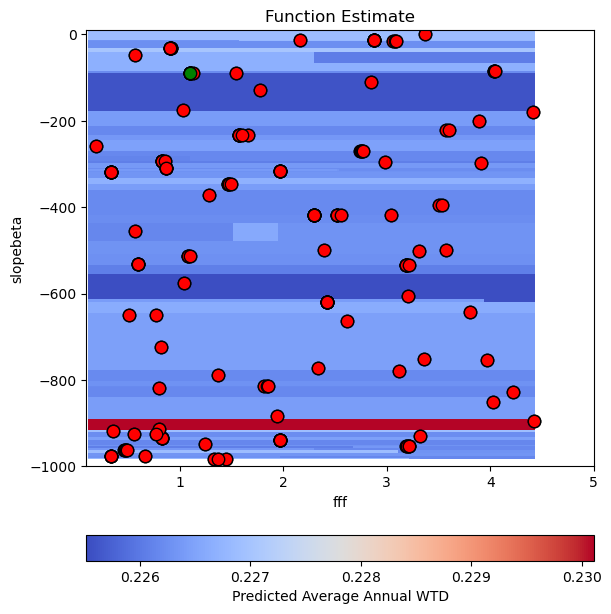

In [8]:
plot_gp_2D(clm_optimizer, acquisition_function, 150, 'fff', 'slopebeta', 0.1, 5, -10e2, 10)

In [21]:
clm_optimizer.max

{'target': 0.2302404020664167,
 'params': {'baseflow': 6.597286183784888,
  'fff': 1.09835576772823,
  'fmax': 0.12999190998310958,
  'slopebeta': -90.19632080321256}}

# Change param file for final run

In [13]:
original_surface_file = '/glade/u/home/marielj/cesm-hillslope/calib-surf-files/surfdata_1x1pt_US-MBP_hist_16pfts_Irrig_CMIP6_simyr2000_HAND_3_col_hillslope_lagg_pftdist_soildepth.nc'
original_param_file = '/glade/u/home/marielj/cesm-hillslope/calib-surf-files/clm50_params.c240105.nc'

target_surface_file = '/glade/u/home/marielj/cesm-hillslope/calib-surf-files/surfdata_1x1pt_US-MBP_hist_16pfts_Irrig_CMIP6_simyr2000_HAND_3_col_hillslope_seanmods.nc'
target_param_file = '/glade/u/home/marielj/cesm-hillslope/calib-param-files/clm50_params.c240105_hillslope_seanmods.nc'

#Create copies of the original surface file in the calib-surf-files and calib-param-files folder
shutil.copyfile(original_surface_file, target_surface_file)
shutil.copyfile(original_param_file, target_param_file)

'/glade/u/home/marielj/cesm-hillslope/calib-param-files/clm50_params.c240105_hillslope_seanmods.nc'

In [22]:
change_surf_param('FMAX' , clm_optimizer.max['params']['fmax'], 0, target_surface_file)
change_param('slopebeta', clm_optimizer.max['params']['slopebeta'], target_param_file)
change_param('fff', clm_optimizer.max['params']['fff'], target_param_file)

Value successfully changed


/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/xarray/coding/times.py:613: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns

Value successfully changed


/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/xarray/coding/times.py:613: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


Value successfully changed


/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [27]:
#Check that changes went through
test_params = xr.load_dataset(target_param_file)

print(test_params.slopebeta)
print(test_params.fff)

<xarray.DataArray 'slopebeta' ()>
array(-90.1963208)
<xarray.DataArray 'fff' ()>
array(1.09835577)


/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [28]:
test_surf = xr.load_dataset(target_surface_file)

print(test_surf.FMAX)

<xarray.DataArray 'FMAX' (lsmlat: 1, lsmlon: 1)>
array([[0.12999191]])
Dimensions without coordinates: lsmlat, lsmlon
Attributes:
    long_name:  maximum fractional saturated area
    units:      unitless
